# High/Low Strategies

Momentum or trend-following strategies refer to trading strategies that rely on following a price trend to completion for profit. An example of a price trend is a sustained price increase due to good earnings beating expectations. 

Momentum strategies use various technical indicators to open a trade when a trend begins and exits when the trend ends. These strategies can be long or short. Momentum strategies is usually contrasted with mean-reversion strategies where traders believe that prices should revert to an expected value. An example of a mean reversion strategy is pairs trading.

Momentum strategies are generally characterised by a low win-rate due to whipsaw losses (indicated trends did not materialise) with great returns from a few winning trades, compared to lower, but more consistent profits for mean reversion trades. This generally produces a lower sharpe ratio for momentum strategies.

Technical indicators for entry include:
- Moving average crossover
- Breakout from highest value in rolling window
- Breakout from All-Time-High

Exit indicators include:
- Moving average crossover
- Breakout from lowest value in rolling window
- Trailing stop



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from utils import misc
import datetime as dt
from trade_obj import *
from simple_backtester import backTester
from mpl_toolkits.mplot3d import Axes3D



ticker = 'SPY'
df = pd.read_csv('datasets/stock_price_series/' + ticker + '.csv')
df = misc.clean_df(df)
df = df.set_index('date')

Generate indicators for entry and exit

In [2]:
def generate_high_low(df, high_window, low_window):

    df['up_bound'] = df['high'].shift(1).rolling(high_window).max()
    df['low_bound'] = df['low'].shift(1).rolling(low_window).min()

    return df

def generate_atr(df, window):
    df['High-Low'] = df['high'] - df['low']
    df['High-PrevClose'] = abs(df['high'] - df['close'].shift(1))
    df['Low-PrevClose'] = abs(df['low'] - df['close'].shift(1))
    df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)
    df['ATR'] = df['TR'].rolling(window).mean()

    return df

def generate_sma(df, long_window, short_window):
    df['long_sma'] = df['close'].rolling(long_window).mean().shift(2)
    df['short_sma'] = df['close'].rolling(short_window).mean().shift(2)

    return df

### High/Low Breakout

In [3]:
def hl_backtest(df, high_window, low_window):

    df = generate_high_low(df, high_window, low_window)

    df.dropna(inplace=True)

    df['signal'] = 0

    # Generate trading signals
    df.loc[df['high'] > df['up_bound'].shift(1), 'signal'] = 1
    df.loc[df['low'] < df['low_bound'].shift(1), 'signal'] = -1
    

    trades_arr = df['signal'].to_numpy()

    bt = backTester()
    bt.set_asset(df)

    tl = tradeList()

    open_trade = None

    for i in range(len(bt.df)):
        
        order_quantity = 0
        order_price = 0

        if trades_arr[i] == 1 and open_trade == None:
    
            # order price at breakout
            order_price = bt.close[i]
            # order 1 unit
            order_quantity = bt.cash // order_price
            # open trade on record
            open_trade = trade(bt.date[i], order_price, order_quantity)
            

        # open trades present 
        elif trades_arr[i] == -1 and open_trade != None:

            order_price = bt.close[i]
            order_quantity = -open_trade.quantity
                
            open_trade.close(bt.date[i], order_price)
            tl.append(open_trade)
            
            open_trade = None

        bt.take_action(order_quantity=order_quantity, order_price=order_price)
        
    
    return bt, tl

In [4]:
hl_period = np.arange(1, 101, 2)
results = []

for i in range(len(hl_period)):
    for j in range(len(hl_period)):
        # print(i, j)
        bt, _ = hl_backtest(df.copy(), hl_period[i], hl_period[j])
        bt.analyse()
        results.append((hl_period[i], hl_period[j], bt.annual_return, bt.annual_vol, bt.sharpe))

In [5]:
print('Buy Hold Results')
print(f'Annual Return = {bt.buy_hold_annual_return}')
print(f'Annual Volatility = {bt.buy_hold_annual_vol}')
print(f'Sharpe Ratio = {bt.buy_hold_sharpe}')
print('-----------')
best_sr = max(results, key=lambda x: x[2])
print(f'Max Total Returns:')
print(f'High Window = {best_sr[0]}, Low Window = {best_sr[1]}')
print(f'Annual Return = {best_sr[2]}')
print(f'Annual Volatility = {best_sr[3]}')
print(f'Sharpe Ratio = {best_sr[4]}')
print('-----------')
best_sr = max(results, key=lambda x: x[4])
print(f'Max Sharpe Ratio:')
print(f'High Window = {best_sr[0]}, Low Window = {best_sr[1]}')
print(f'Annual Return = {best_sr[2]}')
print(f'Annual Volatility = {best_sr[3]}')
print(f'Sharpe Ratio = {best_sr[4]}')
print('-----------')


Buy Hold Results
Annual Return = 0.14713606057229112
Annual Volatility = 0.18954101220552028
Sharpe Ratio = 0.7762755873264555
-----------
Max Total Returns:
High Window = 3, Low Window = 95
Annual Return = 0.11267256088290356
Annual Volatility = 0.16845187517531435
Sharpe Ratio = 0.6688709209419064
-----------
Max Sharpe Ratio:
High Window = 93, Low Window = 95
Annual Return = 0.10462291535322943
Annual Volatility = 0.11298336905684553
Sharpe Ratio = 0.9260027933897981
-----------


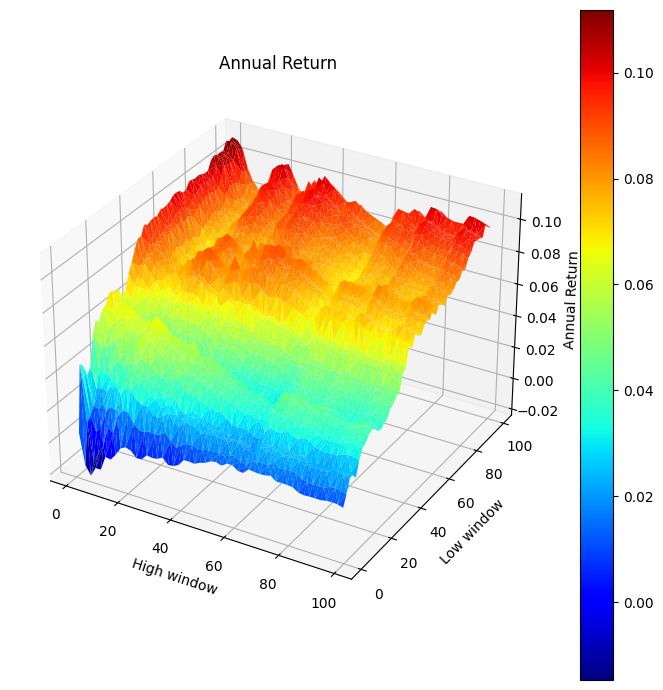

In [6]:
x = np.array([f[0] for f in results])
y = np.array([f[1] for f in results])
z = np.array([f[2] for f in results])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('High window')
ax.set_ylabel('Low window')
ax.set_zlabel('Annual Return')
ax.set_title('Annual Return')

fig.tight_layout()

plt.show()

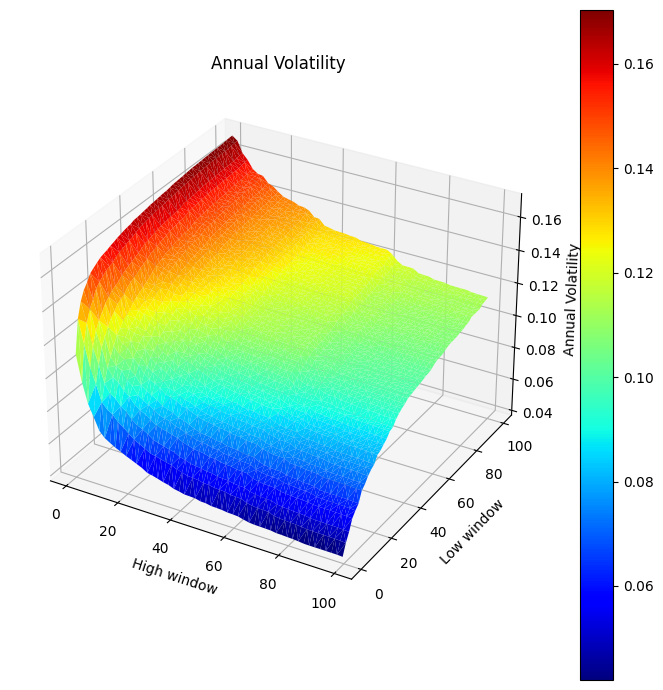

In [7]:
x = np.array([f[0] for f in results])
y = np.array([f[1] for f in results])
z = np.array([f[3] for f in results])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('High window')
ax.set_ylabel('Low window')
ax.set_zlabel('Annual Volatility')
ax.set_title('Annual Volatility')

fig.tight_layout()

plt.show()

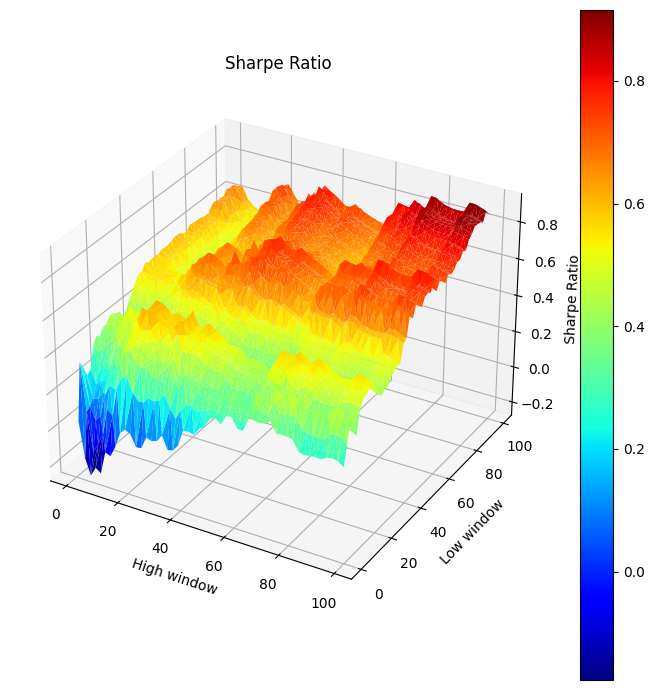

In [8]:
x = np.array([f[0] for f in results])
y = np.array([f[1] for f in results])
z = np.array([f[4] for f in results])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='jet', linewidth=0)
fig.colorbar(surf)

# Set labels and title
ax.set_xlabel('High window')
ax.set_ylabel('Low window')
ax.set_zlabel('Sharpe Ratio')
ax.set_title('Sharpe Ratio')

fig.tight_layout()

plt.show()

### Portfolio Stats

This section looks at the stats of a portfolio that runs this trade at no leverage.

This portfolio has lower returns and lower volatility/drawdowns compared to a buy-hold strategy. The portfolio manages to avoid the large drawdown events, thus preserving capital.

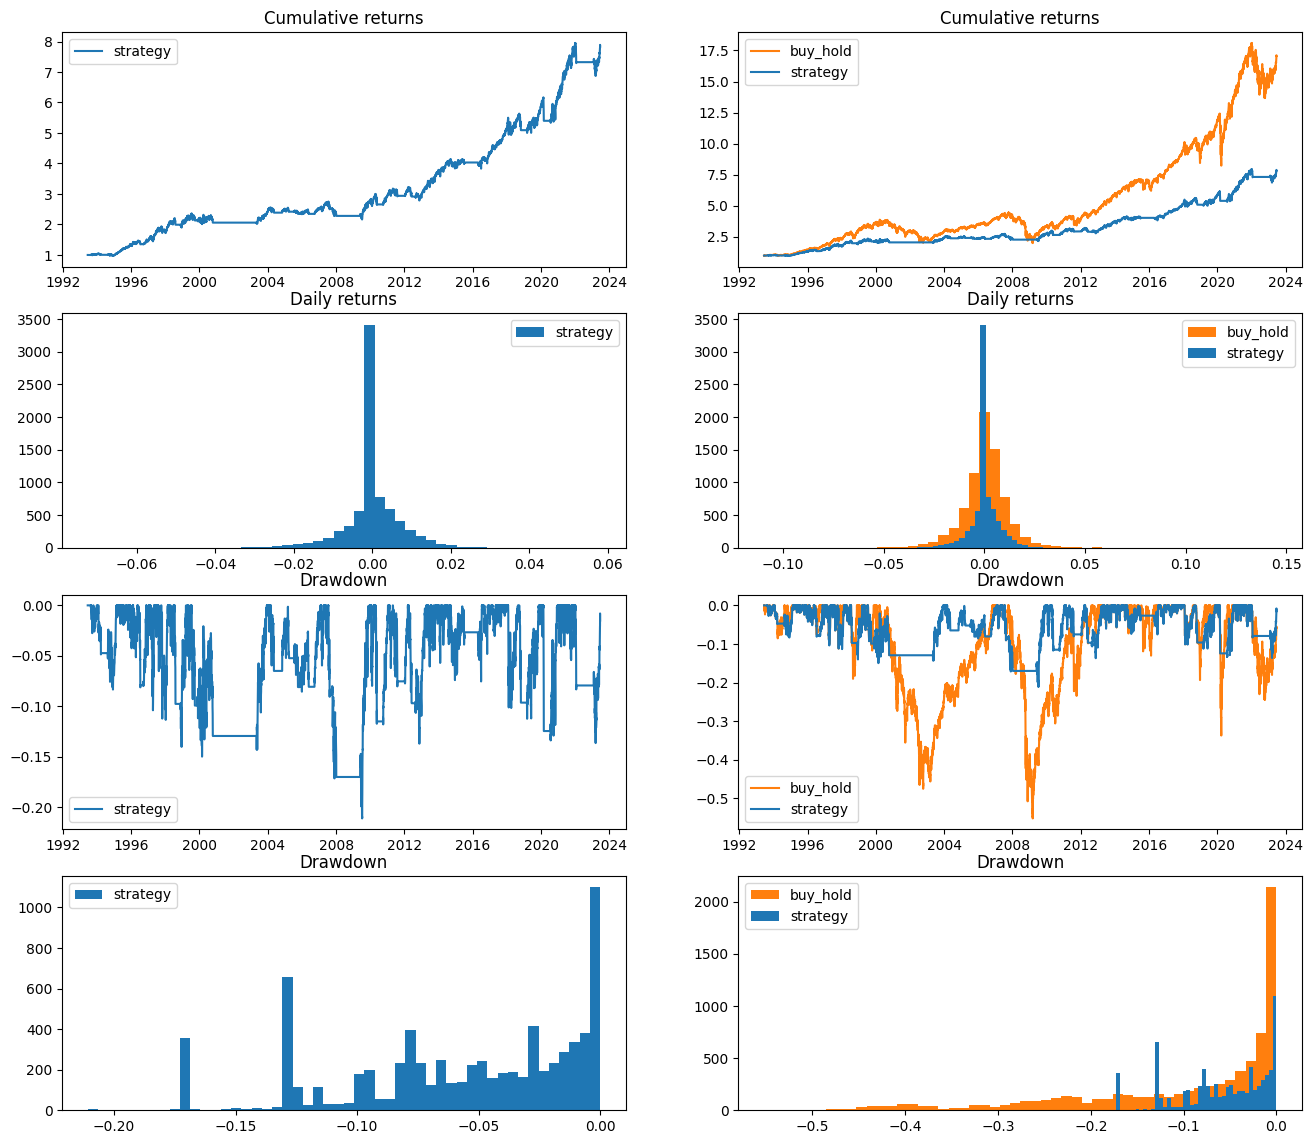

In [9]:
bt, tl = hl_backtest(df.copy(), best_sr[0], best_sr[1])

bt.analyse()
bt.plot_graphs()

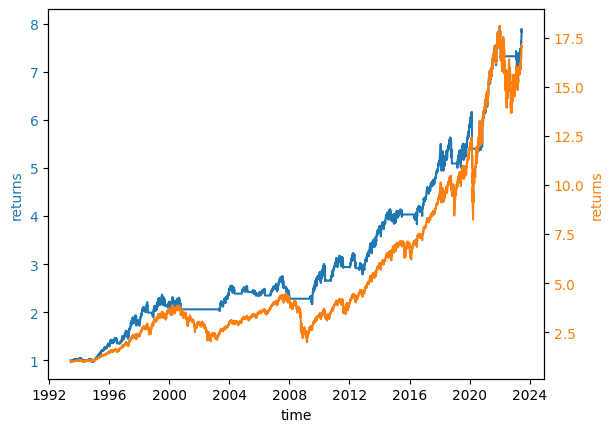

In [10]:
fig, ax1 = plt.subplots()

color = 'C0'
ax1.set_xlabel('time')
ax1.set_ylabel('returns', color=color)
ax1.plot(bt.date, bt.records['cum_returns'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'C1'
ax2 = ax1.twinx()
ax2.set_ylabel('returns', color=color)
ax2.plot(bt.date, bt.records['buy_hold_cum_returns'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.set_facecolor('xkcd:white')
plt.show()

In [11]:
print(f'Annualised return:          {bt.annual_return}')
print(f'buy_hold annual return:     {bt.buy_hold_annual_return}')
print('---------')
print(f'Annualised vol:             {bt.annual_vol}')
print(f'buy_hold annual vol:        {bt.buy_hold_annual_vol}')
print('---------')
print(f'Sharpe ratio:               {bt.sharpe}')
print(f'buy_hold Sharpe ratio:      {bt.buy_hold_sharpe}')

Annualised return:          0.10462291535322943
buy_hold annual return:     0.1469417965490616
---------
Annualised vol:             0.11298336905684553
buy_hold annual vol:        0.1894985156796152
---------
Sharpe ratio:               0.9260027933897981
buy_hold Sharpe ratio:      0.7754245252110356


### Trade record stats

This section looks at the backtest results on a trade-by-trade basis.

In [12]:
tl.analyse(bt.df)
tl.stats

{'num_wins': 16,
 'num_loss': 4,
 'win_rate': 0.8,
 'profit_total': 6323000.682792665,
 'profit_mean': 316150.0341396333,
 'returns_mean': 0.11318192685711663,
 'returns_std': 0.14408249413792854,
 'time_in_trade_mean': 354.6,
 'time_in_trade_std': 225.71486437538843,
 'capital_at_risk_mean': 2630334.616637802,
 'win_returns_mean': 0.15182947701822147,
 'win_returns_std': 0.13437869383086287,
 'win_profit_mean': 420469.12781858456,
 'win_time_in_trade_mean': 402.375,
 'win_time_in_trade_std': 223.0428583628417,
 'loss_returns_mean': -0.041408273787302566,
 'loss_returns_std': 0.03687992322559549,
 'loss_profit_mean': -101126.3405761718,
 'loss_time_in_trade_mean': 163.5,
 'loss_time_in_trade_std': 114.2788986062898}

We plot every single trade to view the characteristics of each trade.

trade 0
entry: [45.78125]
cost_basis: 45.78125
exit: 46.0
returns: 0.00477815699658703


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


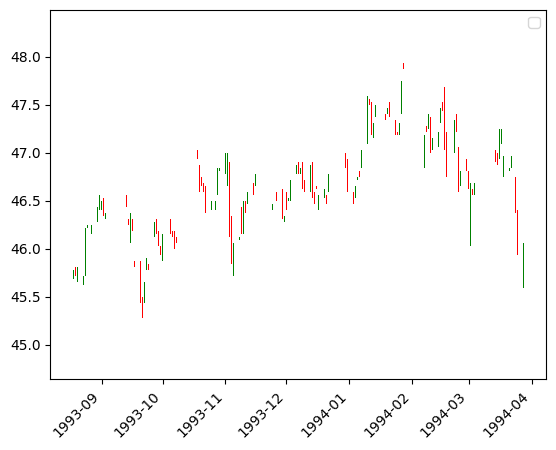

trade 1
entry: [46.640625]
cost_basis: 46.640625
exit: 62.8125
returns: 0.34673366834170855


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


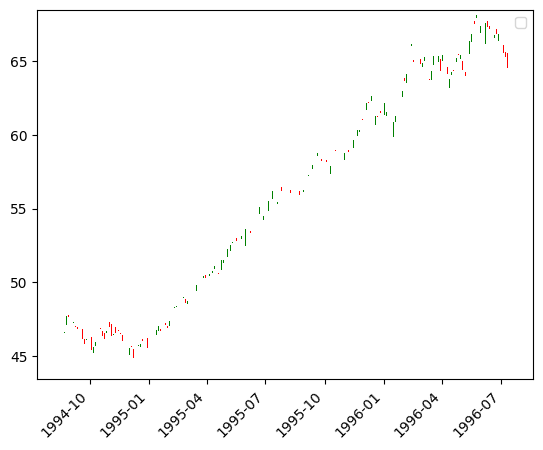

trade 2
entry: [68.5625]
cost_basis: 68.5625
exit: 92.21875
returns: 0.3450319051959891


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


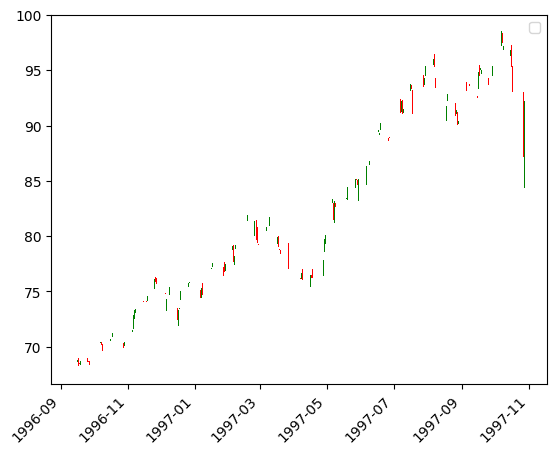

trade 3
entry: [97.78125]
cost_basis: 97.78125
exit: 107.0
returns: 0.09427932246724192


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


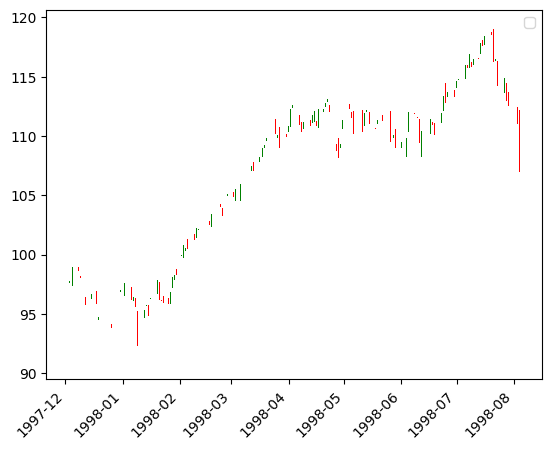

trade 4
entry: [119.375]
cost_basis: 119.375
exit: 127.75
returns: 0.07015706806282722


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


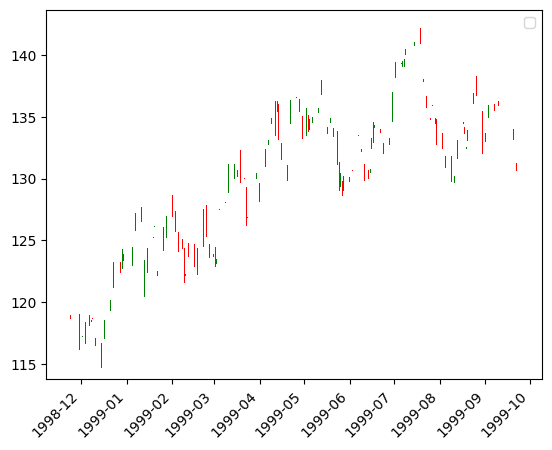

trade 5
entry: [141.25]
cost_basis: 141.25
exit: 136.53125
returns: -0.0334070796460177


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


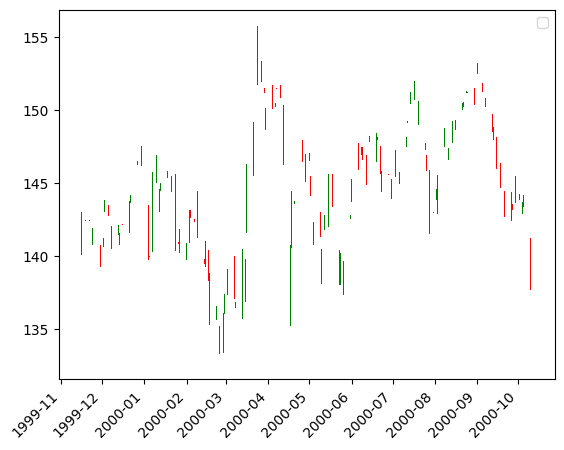

trade 6
entry: [93.91000366210938]
cost_basis: 93.91000366210938
exit: 108.83000183105467
returns: 0.15887549342057145


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


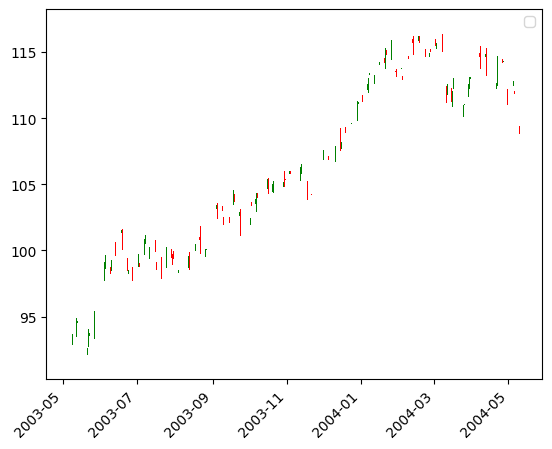

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


trade 7
entry: [114.9800033569336]
cost_basis: 114.9800033569336
exit: 116.52999877929688
returns: 0.013480565116628278


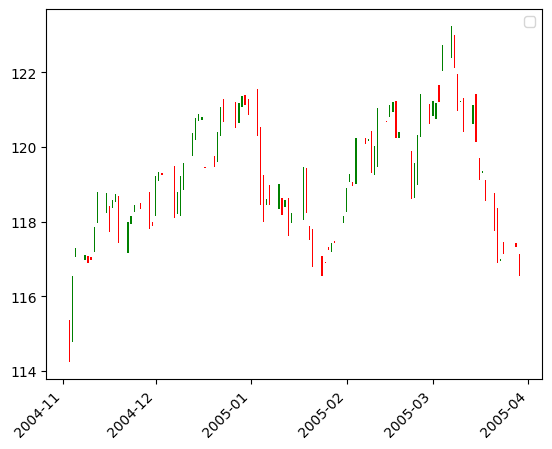

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


trade 8
entry: [122.91000366210938]
cost_basis: 122.91000366210938
exit: 119.1999969482422
returns: -0.030184741707976144


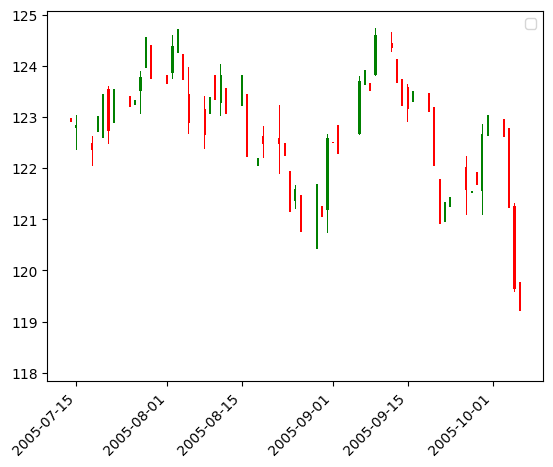

trade 9
entry: [125.12999725341795]
cost_basis: 125.12999725341794
exit: 125.16999816894533
returns: 0.0003196748693790429


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


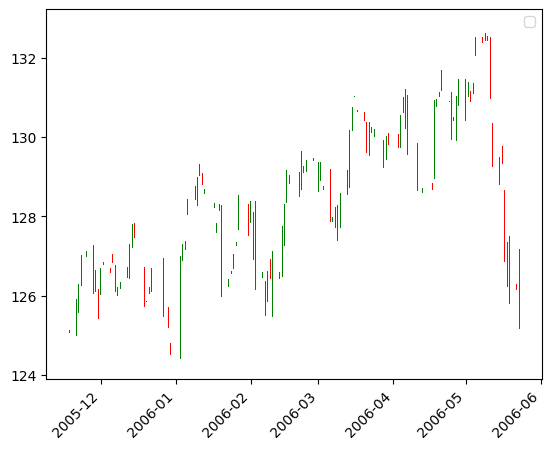

trade 10
entry: [132.47999572753906]
cost_basis: 132.47999572753906
exit: 142.10000610351562
returns: 0.07261481496241337


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


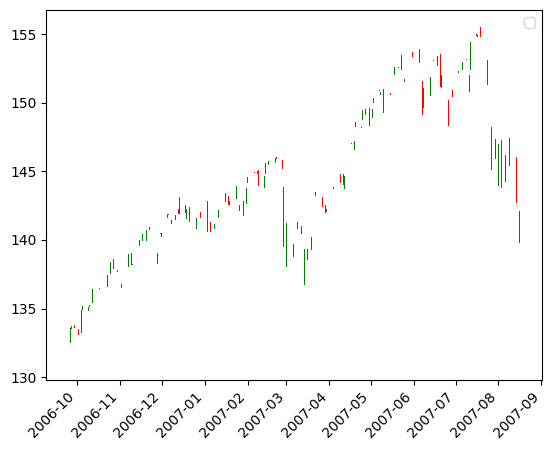

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


trade 11
entry: [155.85000610351562]
cost_basis: 155.85000610351562
exit: 141.19000244140625
returns: -0.09406482571692808


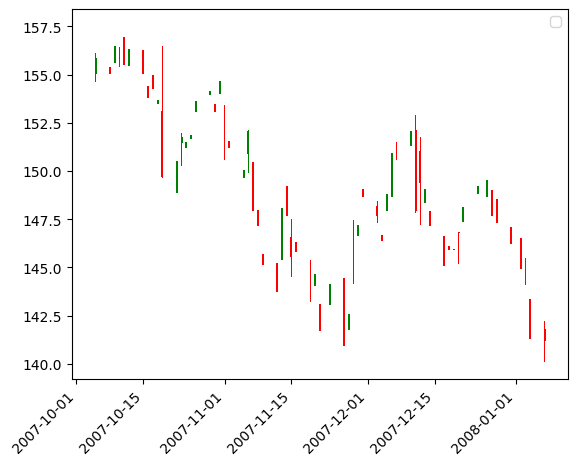

trade 12
entry: [92.52999877929688]
cost_basis: 92.52999877929688
exit: 107.81999969482422
returns: 0.16524371681877084


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


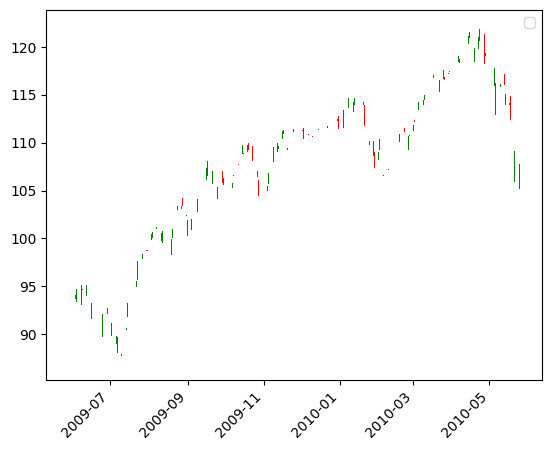

trade 13
entry: [114.12999725341795]
cost_basis: 114.12999725341795
exit: 126.16999816894533
returns: 0.10549374577477087


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


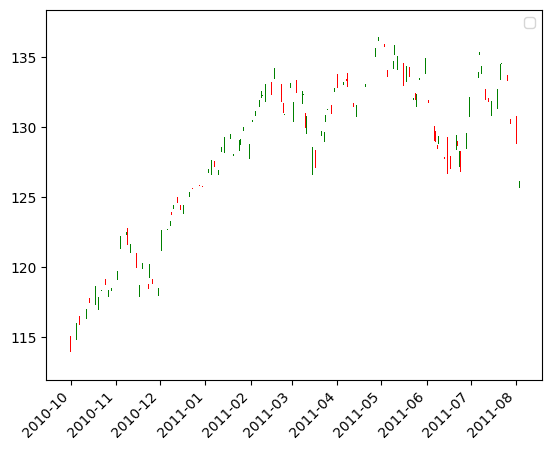

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


trade 14
entry: [129.1300048828125]
cost_basis: 129.1300048828125
exit: 128.10000610351562
returns: -0.00797644807828835


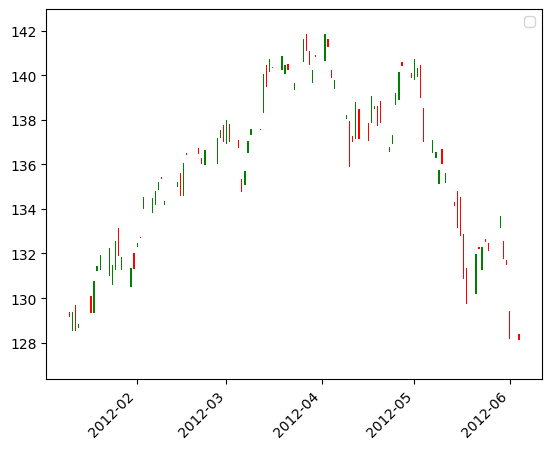

trade 15
entry: [141.99000549316406]
cost_basis: 141.99000549316406
exit: 190.5399932861328
returns: 0.3419253885112789


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


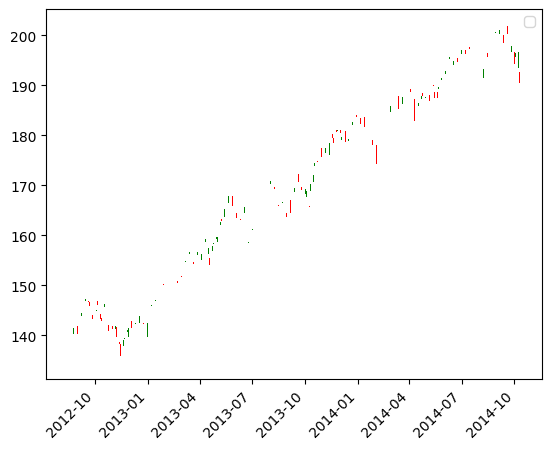

trade 16
entry: [201.7700042724609]
cost_basis: 201.7700042724609
exit: 208.0200042724609
returns: 0.03097586295116636


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


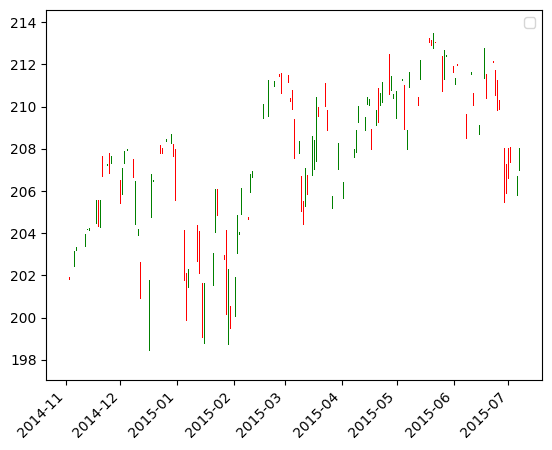

trade 17
entry: [210.1000061035156]
cost_basis: 210.1000061035156
exit: 265.32000732421875
returns: 0.2628272233057263


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


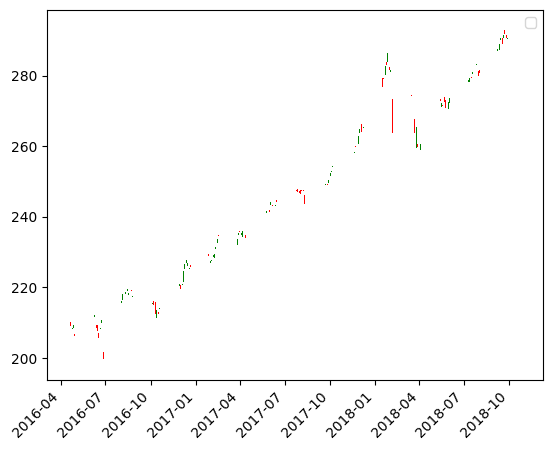

trade 18
entry: [279.3999938964844]
cost_basis: 279.3999938964844
exit: 296.260009765625
returns: 0.06034365152988205


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


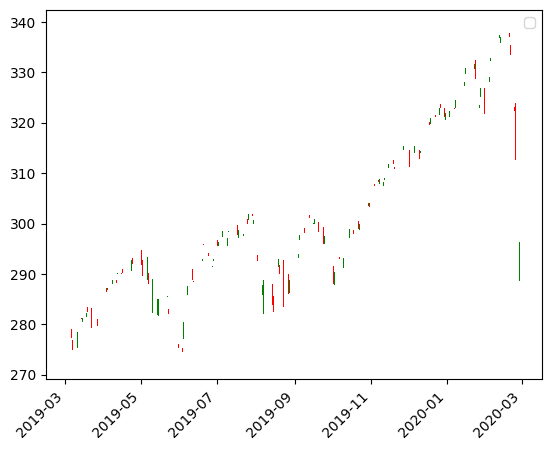

trade 19
entry: [324.32000732421875]
cost_basis: 324.32000732421875
exit: 439.8399963378906
returns: 0.35619137396660194


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


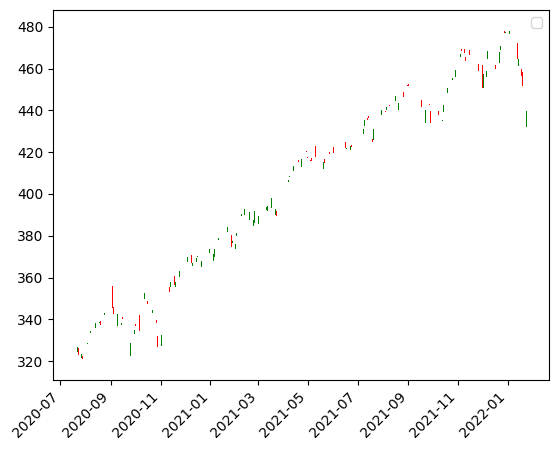

In [13]:
tl.plot_all_trades()

We can plot the trades that occur over a specific period of time to see how this strategy perform.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


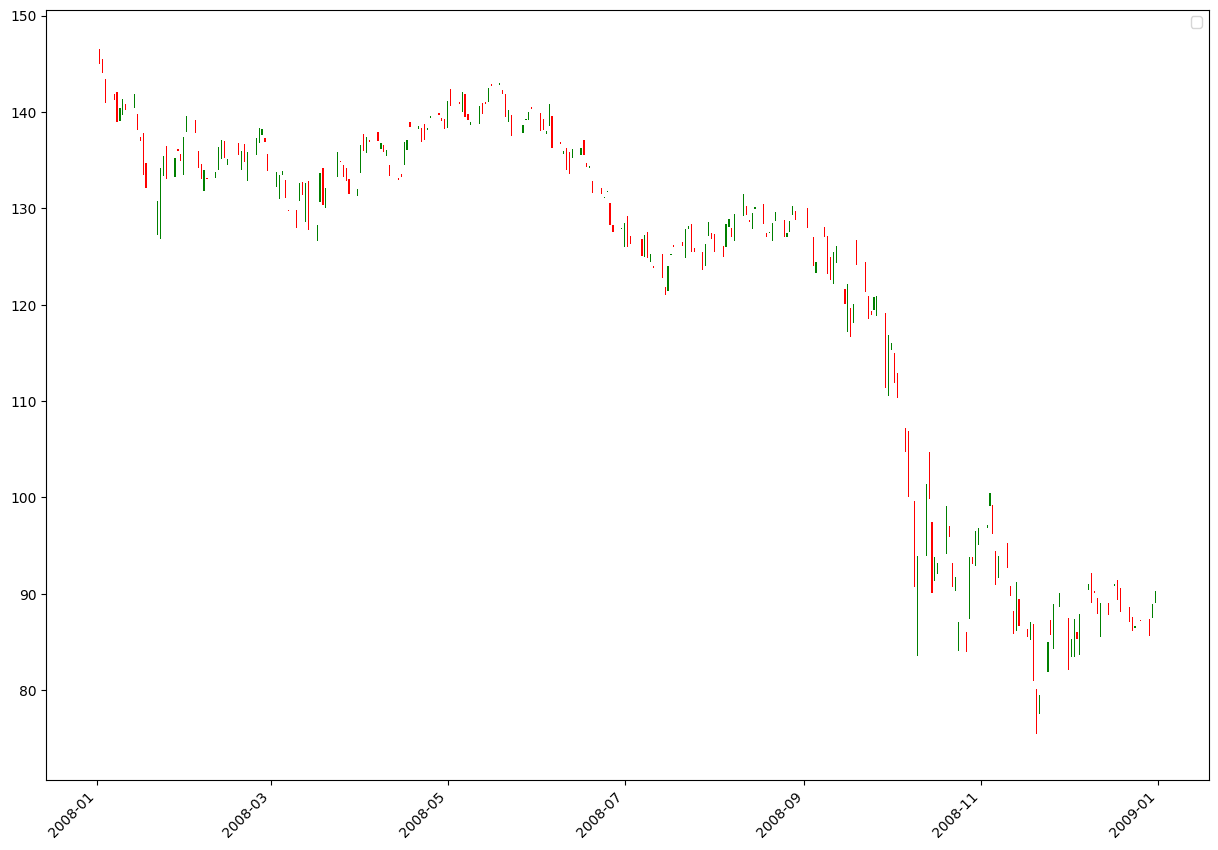

In [14]:

start_datetime= pd.to_datetime(dt.date(2008, 1, 1))
end_datetime = pd.to_datetime(dt.date(2009, 1, 1))

tl.plot_time_period(df, start_datetime, end_datetime)

We note that the time in trade for winning trades is generally higher than that of losing trades.

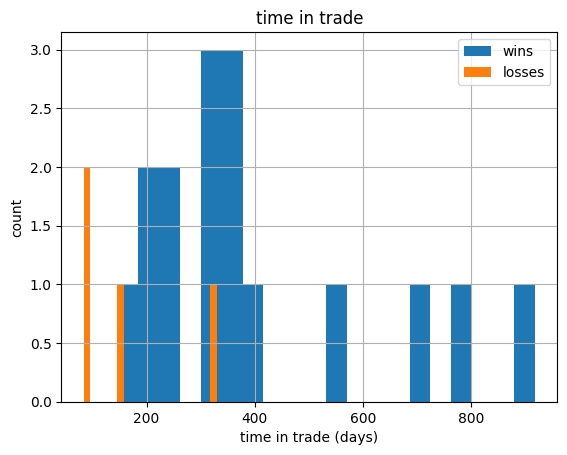

In [15]:
tl.win_records['time_in_trade'].hist(bins=20, label='wins')
tl.loss_records['time_in_trade'].hist(bins=20, label='losses')
plt.xlabel('time in trade (days)')
plt.ylabel('count')
plt.title('time in trade')
plt.legend()
plt.show()

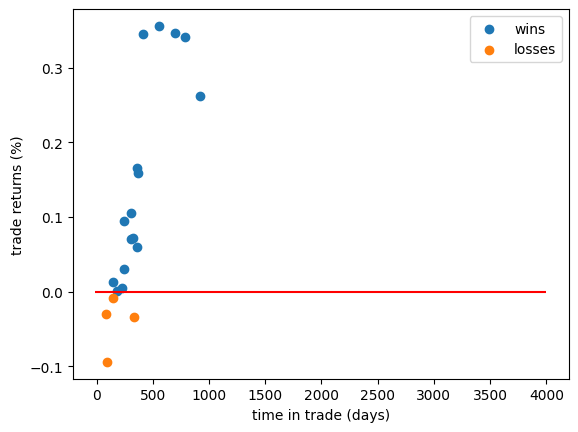

In [16]:
plt.scatter(tl.win_records['time_in_trade'], tl.win_records['returns'], label='wins')
plt.scatter(tl.loss_records['time_in_trade'], tl.loss_records['returns'], label='losses')
plt.hlines(0, -10, 4000, color='red')
plt.legend()
plt.xlabel('time in trade (days)')
plt.ylabel('trade returns (%)')
plt.show()

### Analysis

We note that the turtle trading rules follow a trend-following or momentum trading strategy. The characteristic of these strategies is greater volatility, with lower win-rate but higher returns per winning trade.

Ideally, the strategy goes long when a long-term upward trend is established and follows the trend until it is exhausted, while avoiding big drawdowns when long-term downward trends are established. 

The downside to this strategy is that short-term volatility is likely to cause whipsaw losses. An example of this is losses when the underlying is trading within a range.

Therefore, the way to optimise this strategy is to pick the underlying to more frequent long-term trends with greater magnitude compared to short-term volatility. It does not matter which direction that long-term trend is in since we can just inverse the rules, e.g. go short when price breaks out under the 20-day low. This is also possibly why the original turtle traders focused on commodity trading, since commodities tend to exhibit trends based on the physical demand and supply of the commodity, whereas equities may be more volatile in the short-term due to speculation.

Another key part to the success of this strategy is to trade diversified and uncorrelated assets so that the various assets will be trending at different times. This will go a long way towards reducing the volatility of a portfolio trading all of these assets.

Another idea is to trade this strategy on leveraged ETFs, for example UPRO (3 x leveraged SP500) instead of trading on SPY. The nature of the ETF (3 x daily returns) is likely to cause the magnitude of long-term trends to increase significantly, thus increasing the returns per winning trade of this strategy. The volatility drag of the leverage should also reduce the number of whipsaw losing trades. Therefore, the overall profitability of this strategy on leveraged ETFs should increase. More testing is required however, since we have to account for a higher expense ratio, tracking error, and a lack of historical data since these ETFs are a relatively recent invention.